In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
import string
from tqdm import tqdm_notebook
from collections import Counter
from spacy.tokens import Token
import pickle as pkl
from nltk.util import ngrams
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_data(data, sentiment):
    X = []
    Y = []
    path = os.getcwd() + '/aclImdb/' + data + '/' + sentiment + '/'
    files = os.listdir(path)
    
    for i in files:
        with open(path + i, 'r') as f:
            X.append(f.readlines()[0])
            if sentiment == 'pos':
                Y.append(1)
            else:
                Y.append(0)
    return X, Y

In [3]:
train_X_pos, train_Y_pos = read_data('train', 'pos')
train_X_neg, train_Y_neg = read_data('train', 'neg')
test_X_pos, test_Y_pos = read_data('test', 'pos')
test_X_neg, test_Y_neg = read_data('test', 'neg')

train_X = train_X_pos + train_X_neg
train_Y = train_Y_pos + train_Y_neg
test_X = test_X_pos + test_X_neg
test_Y = test_Y_pos + test_Y_neg

train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, train_size = 0.8, shuffle = True)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
stopwords = tokenizer.Defaults.stop_words

def preprocess(review, remove_html, remove_punc, remove_stopwords):
    preprocessed = []
    
    if remove_html == 'yes' and remove_punc == 'yes' and remove_stopwords == 'yes':
        for token in review:
            token = token.text.replace('<br', '').replace('/>', '').lower()
            if token not in punctuations and token not in stopwords and token != ' ':
                preprocessed.append(token)
                
    elif remove_html == 'yes' and remove_punc == 'yes':
        for token in review:
            token = token.text.replace('<br', '').replace('/>', '').lower()
            if token not in punctuations and token != ' ':
                preprocessed.append(token)
                
    elif remove_html == 'yes' and remove_stopwords == 'yes':
        for token in review:
            token = token.text.replace('<br', '').replace('/>', '').lower()
            if token not in stopwords and token != ' ':
                preprocessed.append(token)
                
    elif remove_punc == 'yes' and remove_stopwords == 'yes':
        for token in review:
            token = token.text.lower()
            if token not in punctuations and token not in stopwords and token != ' ':
                preprocessed.append(token)
                
    elif remove_punc == 'yes':
        for token in review:
            token = token.text.lower()
            if token not in punctuations:
                preprocessed.append(token)
                
    elif remove_html == 'yes':
        for token in review:
            token = token.text.replace('<br', '').replace('/>', '').lower()
            if token != ' ':
                preprocessed.append(token)
        
    elif remove_stopwords == 'yes':
        for token in review:
            token = token.text.lower()
            if token not in stopwords and token != ' ':
                preprocessed.append(token)
                
    else:
        preprocessed = [token.text for token in review]
        
    return preprocessed

def tokenize_dataset(dataset, remove_html, remove_punc, remove_stopwords, ngram):
    token_dataset = []
    all_tokens = []
    
    for i in tqdm_notebook(tokenizer.pipe(dataset, 
                                          disable=['parser', 'tagger', 'ner'], 
                                          batch_size=512, 
                                          n_threads=1)):
        tokens = preprocess(i, remove_html = remove_html, remove_punc = remove_punc, remove_stopwords = remove_stopwords)
        tokens_ = tokens.copy()
        for i in range(2, ngram+1):
            n_grams = ngrams(tokens, i)
            token_n_grams = [' '.join(grams) for grams in n_grams]
            tokens_ += token_n_grams
        
        token_dataset.append(tokens_)
        all_tokens += tokens
    return token_dataset, all_tokens

In [112]:
#parameters
remove_html = 'yes'
remove_punc = 'yes'
remove_stopwords = 'yes'
ngram = 1
max_vocab_size = 30000
MAX_SENTENCE_LENGTH = 200


print ("Tokenizing train data")
train_tokens, all_train_tokens = tokenize_dataset(train_X, remove_html = remove_html, remove_punc = remove_punc, remove_stopwords = remove_stopwords, ngram = ngram)

print ("Tokenizing validation data")
val_tokens, _ = tokenize_dataset(val_X, remove_html = remove_html, remove_punc = remove_punc, remove_stopwords = remove_stopwords, ngram = ngram)

print ("Tokenizing test data")
test_tokens, _ = tokenize_dataset(test_X, remove_html = remove_html, remove_punc = remove_punc, remove_stopwords = remove_stopwords, ngram = ngram)

Tokenizing train data



Tokenizing validation data



Tokenizing test data


In [113]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [114]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_tokens)
val_data_indices = token2index_dataset(val_tokens)
test_data_indices = token2index_dataset(test_tokens)

In [115]:
class reviewDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of review tokens 
        @param target_list: list of review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def review_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader

BATCH_SIZE = 32
train_dataset = reviewDataset(train_data_indices, train_Y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=review_collate_func,
                                           shuffle=True)

val_dataset = reviewDataset(val_data_indices, val_Y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                         collate_fn=review_collate_func,
                                         shuffle=True)

test_dataset = reviewDataset(test_data_indices, test_Y)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          collate_fn=review_collate_func,
                                          shuffle=False)

In [116]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [136]:
#Parameters
emb_dim = 100
learning_rate = 0.01
num_epochs = 10 # number epoch to train

model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  

# Linear annealing of learning rate
step_size = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma = 0.1, last_epoch = -1)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

loss_hist = []
val_acc_hist = []
for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        if i > 0 and i % 100 == 0:
            train_acc = test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            loss_ = loss.item()
            print('Epoch: [{}/{}], Step: [{}/{}], Training Loss: {}, Train Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss_, train_acc, val_acc))
    
            loss_hist.append(loss_)
            val_acc_hist.append(val_acc)

Epoch: [1/10], Step: [101/625], Training Loss: 0.4864580035209656, Train Acc: 83.94, Validation Acc: 82.82
Epoch: [1/10], Step: [201/625], Training Loss: 0.4438627362251282, Train Acc: 88.98, Validation Acc: 86.92
Epoch: [1/10], Step: [301/625], Training Loss: 0.6934552788734436, Train Acc: 91.54, Validation Acc: 88.62
Epoch: [1/10], Step: [401/625], Training Loss: 0.271560937166214, Train Acc: 92.865, Validation Acc: 88.8
Epoch: [1/10], Step: [501/625], Training Loss: 0.37702676653862, Train Acc: 94.47, Validation Acc: 88.9
Epoch: [1/10], Step: [601/625], Training Loss: 0.25000664591789246, Train Acc: 95.5, Validation Acc: 88.62
Epoch: [2/10], Step: [101/625], Training Loss: 0.17669811844825745, Train Acc: 96.585, Validation Acc: 89.86
Epoch: [2/10], Step: [201/625], Training Loss: 0.12436854839324951, Train Acc: 96.69, Validation Acc: 89.86
Epoch: [2/10], Step: [301/625], Training Loss: 0.14054833352565765, Train Acc: 96.755, Validation Acc: 89.82
Epoch: [2/10], Step: [401/625], Trai

Test Set Accuracy: 86.768


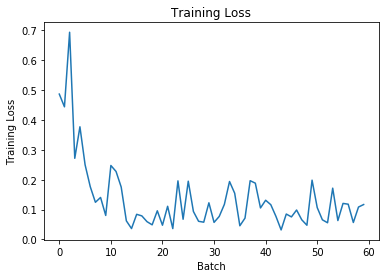

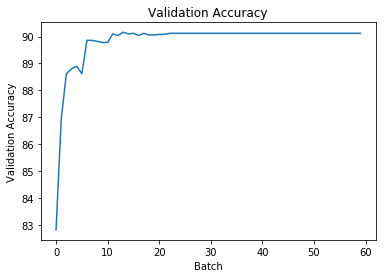

In [225]:
print("Test Set Accuracy: {}".format(test_model(test_loader, model)))

fig1 = plt.figure(1)
plt.plot(loss_hist)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
fig1.savefig('Training Loss.png', dpi = 100)
plt.show()

fig2 = plt.figure(2)
plt.plot(val_acc_hist)
plt.xlabel('Batch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
fig2.savefig('Validation Accuracy', dpi = 100)
plt.show()

In [198]:
data_batch, length_batch, label_batch = next(iter(val_loader))
outputs = F.softmax(model(data_batch, length_batch), dim=1)
predicted = outputs.max(1, keepdim=True)[1]
correct = predicted.eq(label_batch.view_as(predicted))

In [226]:
#Correct: IDX = 0, 1, 2
#Incorrect: IDX = 26, 27, 28

correct_idx = [0,1,2]
incorrect_idx = [26,27,28]
correct_dict = {}
incorrect_dict = {}

for i in correct_idx:
    words = []
    for j in data_batch[i]:
        words.append(id2token[j])
        sent = ' '.join(words)
        correct_dict[i] = sent

for i in incorrect_idx:
    words = []
    for j in data_batch[i]:
        words.append(id2token[j])
        sent = ' '.join(words)
        incorrect_dict[i] = sent

print("Three Correct Predictions:\n{}".format(correct_dict))
print("Three Incorrect Predictions:\n{}".format(incorrect_dict))

Three Correct Predictions:
{0: "worst films seen bad tv movie level standards plot diabolically flawed known names film wasted confused uncertain characters n't know director managed excuse film bad billed psychological horror thriller certainly horrific thrilling psychological damage initial opening scenes held promise possible <unk> soul aspect brain utter shambles followed car crash scene belief matter hard try n't care characters sprinkled ideas film best collage disconnected phrases chinese <unk> worst film actually brain <unk> purchased 300 films dvd 'm going money steer clear <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p